#Predicting oil price using PGM

In [5]:
import pandas as pd
import numpy as np

In [6]:
!pip install EIA_python

In [7]:
import eia
eia_key = "fbPgtRfq693JeuSZKbIknFkrHo329n0NUrxbO5nO"
eia_api = eia.API(eia_key)

In [111]:
import requests

# EIA API key and series ID
eia_key = ""

def get_eia_data(series_id):
  # API v2 endpoint
  url = f"https://api.eia.gov/v2/seriesid/{series_id}"

  # Make the API request
  params = {"api_key": eia_key}
  response = requests.get(url, params=params)

  # Check response status
  if response.status_code == 200:
      # Parse JSON response
      data = response.json()

      if 'response' in data and 'data' in data['response']:
          # Extract the data
          series_data = data['response']['data']

          # Convert to DataFrame
          eia_data = pd.DataFrame(series_data)
          try:
            eia_data = eia_data[['period', 'value']]
            eia_data['value'] = pd.to_numeric(eia_data['value'], errors='coerce')
            eia_data.rename(columns={'value': series_id}, inplace=True)
          except Exception as e:
            print(f"An unexpected error occurred: {e}")

          #print(eia_data)
          return eia_data
      else:
          print("Error: No data found in response.")
  else:
      print(f"Error: HTTP {response.status_code} - {response.text}")

In [113]:
eia_data = get_eia_data('STEO.RGDPQ_NONOECD.M')
eia_data.head(n=10)

An unexpected error occurred: "None of [Index(['period', 'value'], dtype='object')] are in the [columns]"


""


In [94]:
eia_data.head(n=10)
eia_data_copy = eia_data.copy()

In [95]:
eia_data = eia_data_copy.copy()

In [96]:
def set_datetime_index(df, date_column='period'):
    """
    Converts a specified column in a DataFrame to datetime and sets it as the index.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The column to convert to datetime and set as the index.

    Returns:
        pd.DataFrame: The DataFrame with a datetime index.
    """
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m')

    # Set the date column as the index
    df.set_index(date_column, inplace=True)

    # Ensure the index is sorted
    df.sort_index(inplace=True)

    return df

In [97]:
def clean_EIA(data):
  data = set_datetime_index(data)
  # Replace the '-' with np.nan
  data.replace('-', np.nan, regex=True, inplace=True)
  # Backward fill the holes, by filling them with the data infront.
  data.fillna(method='bfill', inplace=True)

clean_EIA(eia_data)

<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [98]:
eia_data.head(n=10)

,TOTAL.COEXPUS.M
period,
1973-01-01,4.129
1973-02-01,4.129
1973-03-01,4.129
1973-04-01,4.129
1973-05-01,4.129
1973-06-01,7.484
1973-07-01,7.484
1973-08-01,5.333
1973-09-01,5.333


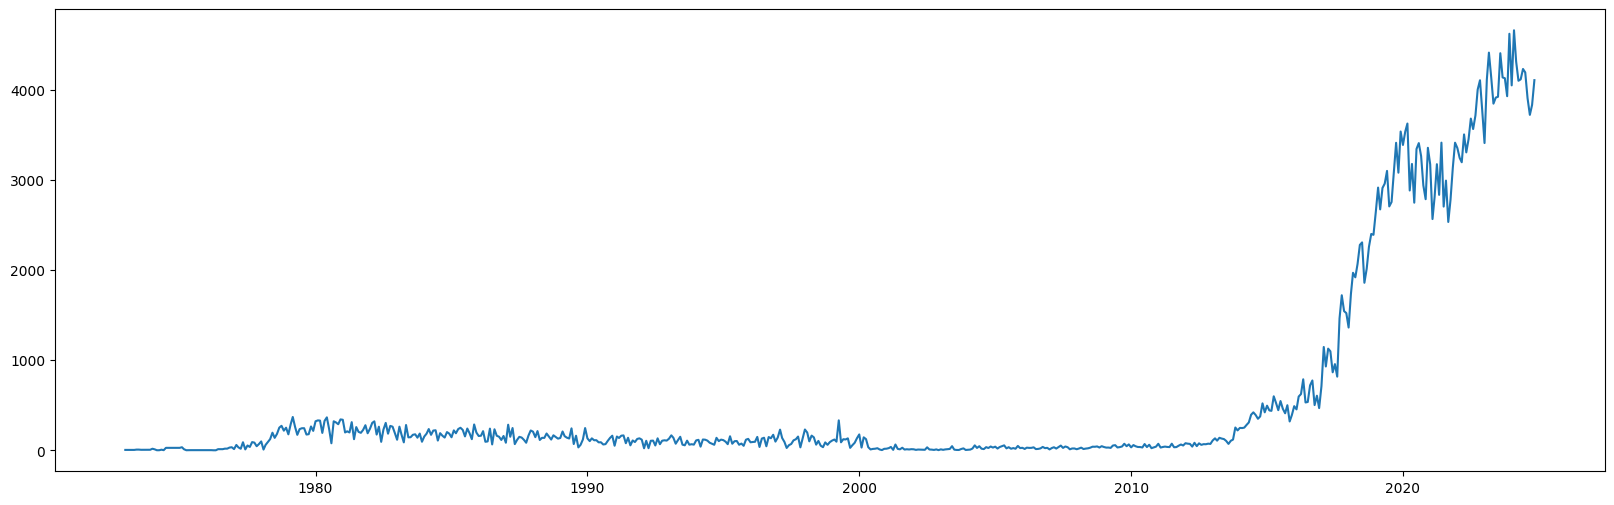

In [99]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(eia_data)

In [54]:
!pip install fredapi

In [55]:
from fredapi import Fred

In [56]:
fred_key = "2aa2af6f7e94bbd5366c17d91b31eb1e"

In [57]:
fred = Fred(api_key=fred_key)

In [58]:
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])

In [59]:
fred_data.head()

,WTISPLC
1946-01-01,1.17
1946-02-01,1.17
1946-03-01,1.17
1946-04-01,1.27
1946-05-01,1.27


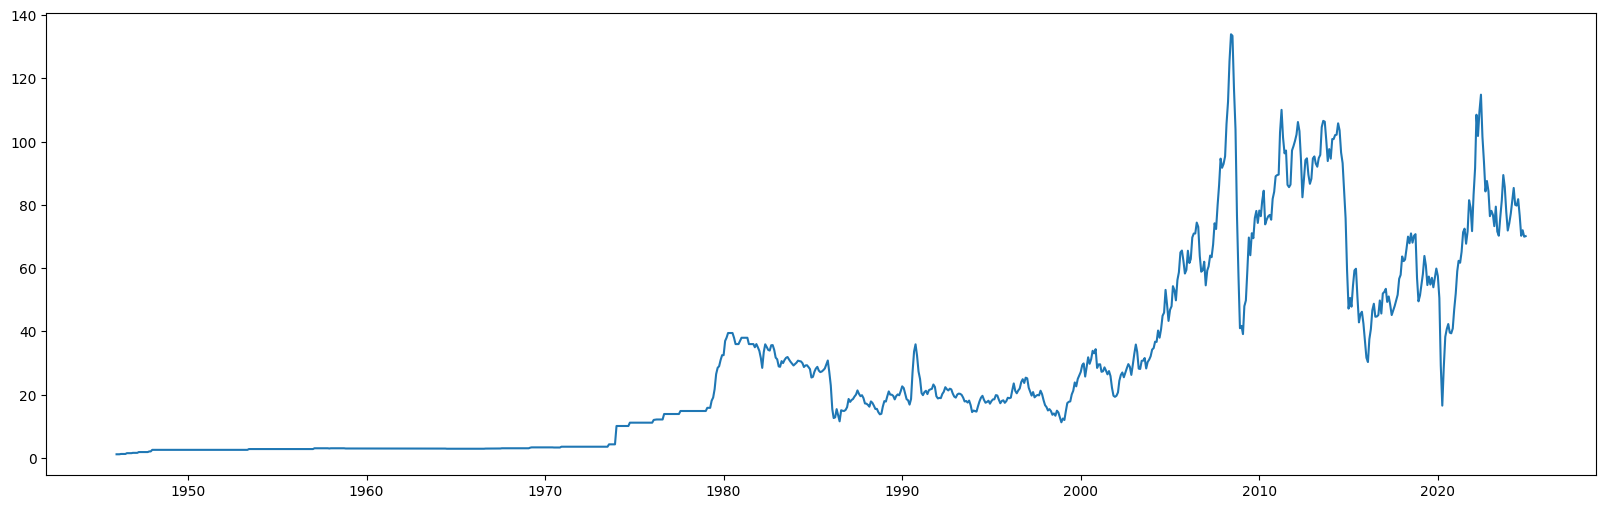

In [85]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(fred_data)

In [100]:
# Dataset series ID from the EIA
datasets_eia = [
    'STEO.RGDPQ_NONOECD.M',
    'STEO.RGDPQ_OECD.M',
    'STEO.PAPR_NONOPEC.M',
    'STEO.PAPR_OPEC.M',
    'STEO.PATC_OECD.M',
    'STEO.PATC_NON_OECD.M',
    'STEO.COPRPUS.M',
    'STEO.CORIPUS.M',
    'PET.MCRIMXX2.M',
    'STEO.FOREX_WORLD.M',
    'STEO.PASC_OECD_T3.M',
    'STEO.COPS_OPEC.M',
    'STEO.COPC_OPEC.M',
    'STEO.T3_STCHANGE_OOECD.M',
    'STEO.T3_STCHANGE_NOECD.M',
]

# Dataset series ID from the FRED
datasets_fred = [
    'CPIENGSL',
    'CAPG211S',
    'CAPUTLG211S',
    'IPG211S',
    'IPG211111CN',
    'INDPRO',
    'IPN213111N',
    'PCU211211',
]

In [116]:
data_merge = [] # List of dataframes to be concatenated
# Adding EIA datasets
for series_id in datasets_eia:
    df = get_eia_data(series_id)
    if df.empty:
        continue
    clean_EIA(df)
    df.columns = [series_id]
    data_merge.append(df)

# Adding FRED datasets
for series_id in datasets_fred:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id])
    data_merge.append(df)

An unexpected error occurred: "None of [Index(['period', 'value'], dtype='object')] are in the [columns]"
An unexpected error occurred: "None of [Index(['period', 'value'], dtype='object')] are in the [columns]"


<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

An unexpected error occurred: "None of [Index(['period', 'value'], dtype='object')] are in the [columns]"


<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-97-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

In [120]:
datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast']
current = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1), columns=['forecast'])
data_merge.append(current)
data_merge.append(forecast)

In [121]:
data = pd.concat(data_merge, axis=1, join='inner')

In [122]:
data.head(n=10)

,STEO.PAPR_NONOPEC.M,STEO.PAPR_OPEC.M,STEO.PATC_OECD.M,STEO.PATC_NON_OECD.M,STEO.COPRPUS.M,STEO.CORIPUS.M,PET.MCRIMXX2.M,STEO.PASC_OECD_T3.M,STEO.COPS_OPEC.M,STEO.COPC_OPEC.M,...,CPIENGSL,CAPG211S,CAPUTLG211S,IPG211S,IPG211111CN,INDPRO,IPN213111N,PCU211211,WTISPLC,forecast
2003-02-01,50.572317,28.735148,51.833658,30.700033,5.782863,14.381,3672,2394.414000,2.364945,28.209000,...,140.8,64.3603,93.6988,60.3048,88.8760,91.2505,90.9680,170.2,35.87,33.55
2003-03-01,50.407735,29.375879,49.263584,30.366344,5.803461,14.933,4883,2463.397002,0.957693,27.399329,...,143.9,64.4112,93.0475,59.9331,89.1924,91.0006,92.6011,220.0,33.55,28.25
2003-04-01,50.062831,28.582918,48.385533,29.932542,5.725816,15.575,5279,2493.210998,0.820811,26.383232,...,136.5,64.4758,92.4022,59.5770,87.9987,90.4311,96.0623,150.2,28.25,28.14
2003-05-01,49.877436,28.720351,47.515557,30.417127,5.663475,15.910,5060,2541.263000,1.185702,26.939523,...,129.4,64.5475,90.8091,58.6150,87.0407,90.4000,101.5265,152.7,28.14,30.72
2003-06-01,49.815246,28.074057,48.119310,30.818835,5.659077,15.620,4722,2584.821001,2.138374,27.177749,...,129.8,64.6205,91.0159,58.8149,86.9731,90.5196,103.1308,169.3,30.72,30.76
2003-07-01,50.423767,28.300441,48.817073,31.118665,5.498445,15.546,4112,2610.785999,2.179302,27.339878,...,132.2,64.6870,90.2706,58.3934,84.5034,90.9869,104.0776,160.7,30.76,31.59
2003-08-01,50.429442,28.850976,48.396000,30.987973,5.573770,15.693,4347,2618.493000,2.195519,27.847362,...,137.8,64.7385,91.6009,59.3010,85.6613,90.7933,105.2404,151.1,31.59,28.29
2003-09-01,50.827849,29.239288,49.236748,31.200883,5.609009,15.446,4798,2632.882999,2.296769,28.287975,...,142.9,64.7704,92.1562,59.6899,86.2021,91.3819,105.5593,149.4,28.29,30.33
2003-10-01,51.128210,29.983055,49.977468,31.625200,5.613544,15.342,4754,2606.625001,2.075483,28.685975,...,137.8,64.7796,91.8105,59.4744,86.2716,91.5049,105.7384,146.1,30.33,31.09
2003-11-01,51.483127,29.994130,49.027492,31.637090,5.546554,15.455,4733,2609.821000,2.155300,28.745589,...,136.9,64.7640,91.0830,58.9890,85.2418,92.1265,106.4785,143.7,31.09,32.15


In [127]:
train_data = data[: int(data.shape[0] * 0.80)]
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])]
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])]

In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.7 MB/s eta 0:00:00


In [3]:
from hmmlearn import hmm

# Step 1: Preprocess data
price = train_data['WTISPLC']
price_diff = price.diff()[1:]  # First differences
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values)  # Binary observations

# Step 2: Define and initialize HMM
n_states = 3  # Number of hidden states
n_observations = 2  # Number of discrete observations (0 or 1)
model = hmm.MultinomialHMM(n_components=n_states, random_state=42, n_iter=100, tol=1e-4)

# Convert observations to a 2D array as required by hmmlearn
e_seq_reshaped = e_seq.reshape(-1, 1)

# Step 3: Train the HMM using Baum-Welch
model.fit(e_seq_reshaped)

# Print parameters
print("Transition Matrix:")
print(model.transmat_)
print("Emission Probabilities:")
print(model.emissionprob_)
print("Start Probabilities:")
print(model.startprob_)

# Step 4: Perform Viterbi decoding
log_prob, s_seq = model.decode(e_seq_reshaped, algorithm="viterbi")

# Output results
print("\nLog Probability of the sequence:", log_prob)
print("Most probable hidden state sequence:", s_seq)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Transition Matrix:
[[9.01320140e-04 9.99058562e-01 4.01179591e-05]
 [9.54638745e-01 7.97928839e-03 3.73819670e-02]
 [4.02174984e-01 1.24429527e-01 4.73395489e-01]]
Emission Probabilities:
[[1.]
 [1.]
 [1.]]
Start Probabilities:
[0.1140845  0.87766916 0.00824634]

Log Probability of the sequence: -2.4513298726714745
Most probable hidden state sequence: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
